# Generate an Image

In [33]:
def generate_with_prompt(prompt=""):
    from diffusers import StableDiffusionPipeline
    import torch

    pipe = StableDiffusionPipeline.from_pretrained(
        '/home/wukailu/.cache/huggingface/diffusers/cache-runwayml--stable-diffusion-v1-5',
        torch_dtype=torch.float16).to("cuda")
    ret = pipe(prompt=prompt)
    return ret.images[0]

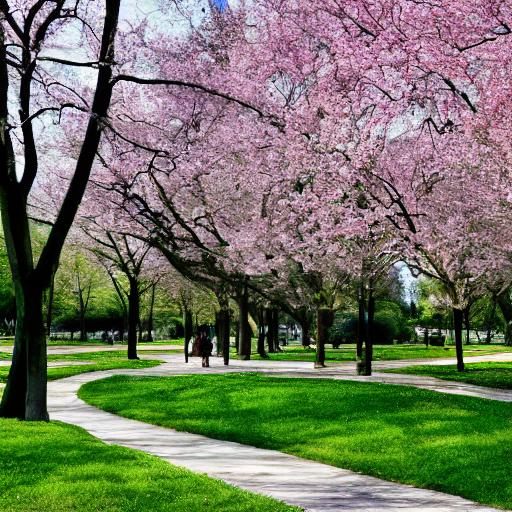

In [344]:
from PIL import Image
prompt = "a photo of a park in the spring"
# exp = generate_with_prompt("a photo of a park in the spring")
# exp.save("example.jpg")
exp = Image.open("example.jpg")
exp

# prepare depth prediction

In [3]:
import sys
sys.path.append("/home/wukailu/latent-nerf/src/ControlNet")

In [4]:
import torch
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector

apply_midas = MidasDetector()
apply_midas_raw = apply_midas.raw_depth

depth_cap = 10  # the maximum predicted depth
disparity_cap = 1.0 / depth_cap
target_disp_mean = 1.0 / (depth_cap / 5)
target_disp_std = target_disp_mean / 2

def pred_disp(input_image, detect_resolution) -> torch.FloatTensor:
    with torch.no_grad():
        input_image = HWC3(input_image)
        detected_map: torch.FloatTensor = apply_midas(resize_image(input_image, detect_resolution))
    return detected_map[0]

def pred_depth(input_image, detect_resolution) -> torch.FloatTensor:
    with torch.no_grad():
        input_image = HWC3(input_image)
        detected_map: torch.FloatTensor = apply_midas_raw(resize_image(input_image, detect_resolution))
        cur_mean = detected_map.mean()
        cur_std = detected_map.std()
        detected_map = ((detected_map-cur_mean)/cur_std * target_disp_std + target_disp_mean).clip(min=disparity_cap)
        detected_map = 1.0 / detected_map
    return detected_map.cpu()

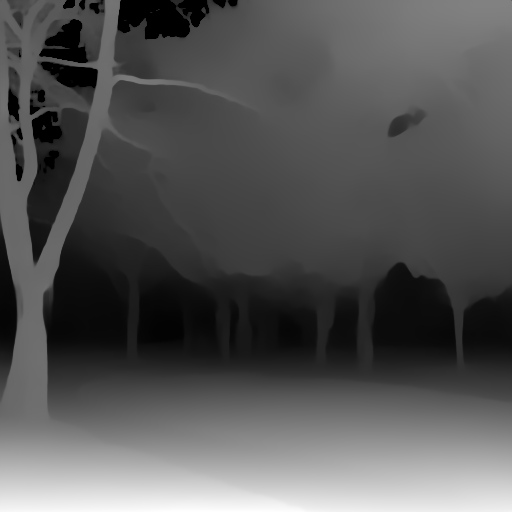

In [221]:
import numpy as np

example_img = np.array(exp)
example_img = example_img[..., :3]
depth = pred_depth(example_img, example_img.shape[0])
disp = pred_disp(example_img, example_img.shape[0])
Image.fromarray(disp)

In [215]:
def calculate_depth_gradient(depth_map):
    """
    计算深度图梯度大小
    """
    # 计算梯度
    gradient = np.gradient(depth_map)
    gradient_mag = np.sqrt(np.sum(np.power(gradient, 2), axis=0))
    return gradient_mag

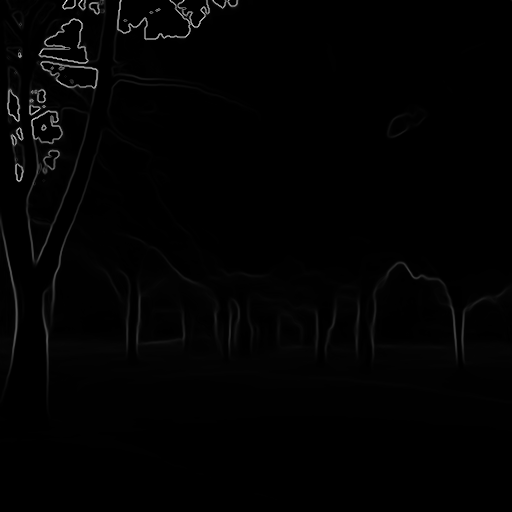

In [230]:
grad_np = calculate_depth_gradient(depth)
import cv2
Image.fromarray(cv2.normalize(grad_np, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U))

# depthmap to point cloud

In [6]:
import torch

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    ray_bundle_to_ray_points,
    NDCMultinomialRaysampler,
)

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [318]:
def save_pcd(pcd, path: str):
    assert path.endswith(".ply")
    from pytorch3d.io import IO
    IO().save_pointcloud(pcd, path)
    return pcd

def rgbd_to_pcd(rgb, depth, cameras, mask=None):
    """
    @param rgb: np.float of shape [H,W,C]
    @param depth: float tensor of shape [H,W]
    @param mask: boolean tensor of shape [H,W] or None
    """
    feat_dim = rgb.shape[-1]
    # upsample the image
    rgb = torch.tensor(rgb).permute((2,0,1)).float()
    rgb = torch.nn.functional.interpolate(rgb[None], (1536, 1536), mode='bilinear')[0].permute((1,2,0))
    depth = torch.nn.functional.interpolate(depth[None, None], (1536, 1536), mode='bilinear')[0, 0]
    if mask is not None:
        mask = torch.tensor(mask)
        mask = torch.nn.functional.interpolate(mask.float(), (1536, 1536), mode='bilinear').round().boolean()
    # convert the depth maps to point clouds using the grid ray sampler
    ray_bundle = NDCMultinomialRaysampler(
            image_width=depth.shape[1],
            image_height=depth.shape[0],
            n_pts_per_ray=1,
            min_depth=0.1,
            max_depth=depth_cap+1,
        )(cameras)
    ray_bundle = ray_bundle._replace(lengths = depth[None, ..., None].to(device))
    pts_3d = ray_bundle_to_ray_points(ray_bundle)
    if mask is not None:
        pts_3d = pts_3d[mask[None]].view(1, -1, 3)
        features = rgb[mask].to(device).reshape(1, -1, feat_dim).float()
    else:
        pts_3d = pts_3d.view(1, -1, 3)
        features = rgb.to(device).reshape(1, -1, feat_dim).float()

    # Sanity check
    return Pointclouds(points=pts_3d, features=features)

In [353]:
from torch import nn
class PointsDepthRenderer(nn.Module):
    """
    A class for rendering a batch of points. The class should
    be initialized with a rasterizer and compositor class which each have a forward
    function.
    """

    def __init__(self, rasterizer, compositor) -> None:
        super().__init__()
        self.rasterizer = rasterizer
        self.compositor = compositor

    def to(self, device):
        # Manually move to device rasterizer as the cameras
        # within the class are not of type nn.Module
        self.rasterizer = self.rasterizer.to(device)
        self.compositor = self.compositor.to(device)
        return self

    def forward(self, point_clouds, **kwargs) -> torch.Tensor:
        fragments = self.rasterizer(point_clouds, **kwargs)

        return fragments.zbuf[..., 0]

In [373]:
@torch.no_grad()
def pcd_render(cameras, point_cloud, image_size=512, radius = 0.003, points_per_pixel = 100):
    # Define the settings for rasterization and shading. Here we set the output image to be of size
    # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
    # and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters.
    raster_settings = PointsRasterizationSettings(
        image_size=image_size,
        radius = radius,
        points_per_pixel = points_per_pixel
    )

    # Create a points renderer by compositing points using an alpha compositor (nearer points
    # are weighted more heavily).
    rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
    renderer = PointsRenderer(
        rasterizer=rasterizer,
        compositor=AlphaCompositor(background_color=[0.] * point_cloud.features_packed().shape[-1])
    )
    images_1 = renderer(point_cloud)  # c

    renderer = PointsRenderer(
        rasterizer=rasterizer,
        compositor=AlphaCompositor(background_color=[1.] * point_cloud.features_packed().shape[-1])
    )
    images_2 = renderer(point_cloud)  # c + alpha * 1

    alpha = (images_2 - images_1).clip(min=0)

    renderer = PointsDepthRenderer(
        rasterizer=rasterizer,
        compositor=AlphaCompositor(background_color=[1.] * point_cloud.features_packed().shape[-1])
    )
    depth_map = renderer(point_cloud)

    return {
        "rgb": images_1,  # [1, H, W, C]
        "alpha": alpha[..., [0]],  # [1, H, W, 1]
        "depth": depth_map[..., None],  # [1, H, W, 1], value -1 if not hit
    }

In [374]:
def collate_dicts(list_of_dicts: list):
    return {k: [d[k] for d in list_of_dicts] for k in list_of_dicts[0]}

In [382]:
def pcd_inpaint(point_cloud, grad_cloud, cameras, prompt="street", num_inference_steps=200, guidance_scale=0, **kwargs):
    """
    @param point_cloud: Point-clouds of pytorch3D
    @param grad_cloud: Corresponding pixel depth grads
    @param cameras: Type of Cameras in pytorch3D
    """
    from PIL import Image, ImageFilter
    import torch
    from diffusers import DiffusionPipeline
    device = "cuda" if torch.cuda.is_available() else "cpu"
    pipe = DiffusionPipeline.from_pretrained(
        '/home/wukailu/.cache/huggingface/diffusers/cache-runwayml--stable-diffusion-inpainting',
        revision="fp16",
        torch_dtype=torch.float16,
    ).to(device)

    renders = collate_dicts([pcd_render(cameras[i], point_cloud) for i in range(len(cameras))])  # for cam in camears has bugs
    images, alphas, depths = torch.cat(renders["rgb"]), torch.cat(renders["alpha"]), torch.cat(renders["depth"])
    print("depths:", depths.shape, depths.min(), depths.max())
    g_renders = collate_dicts([pcd_render(cameras[i], grad_cloud) for i in range(len(cameras))])
    grads = torch.cat(g_renders["rgb"])  # [1, 512, 512, 1]
    ret = []

    for image, alpha, grad, r_depth in zip(images, alphas, grads, depths):
        image_pil = Image.fromarray((image.cpu().numpy()*255).round().astype(np.uint8))
        # display(image_pil)  # check results
        # return None
        mask = ((alpha>0.05).float().expand_as(image).cpu().numpy()*255).round().astype(np.uint8)
        mask_grad = ((grad>0.5).float().expand_as(image).cpu().numpy()*255).round().astype(np.uint8)
        mask_pil = Image.fromarray(mask | mask_grad)
        blur_pil = mask_pil.filter(ImageFilter.GaussianBlur(radius = 2))
        np_blur = np.array(blur_pil)
        np_blur[np_blur > 10] = 255
        np_blur[np_blur <= 10] = 0
        print((np_blur > mask).sum(), (np_blur < mask).sum())
        bin_blur_pil = Image.fromarray(np_blur | mask)
        with torch.cuda.amp.autocast():
            output = pipe(prompt=prompt, image=image_pil, mask_image=bin_blur_pil, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, **kwargs)
        ret.append(
            {
                "image_pil": image_pil,
                "rendered_depth": r_depth,
                "bin_mask_pil": bin_blur_pil,
                "inpaint_pil": output.images[0],
                "mask_pil": Image.fromarray(mask),
                "grad_pil": Image.fromarray(mask_grad),
            }
        )
    return ret

In [383]:
R, T = look_at_view_transform(5, 0, 0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01, zfar=depth_cap*2)
point_cloud = rgbd_to_pcd(example_img / 255.0, depth, cameras)
grad_cloud = rgbd_to_pcd(grad_np[..., None], depth, cameras)

In [384]:
# Create camera for viewing the point clouds
# angle_list = [(i, j) for i in [-3, 0, 3] for j in [-6, -3, 0, 3, 6] if (i!=0) or (j!=0)]
angle_list = [(0, 3), (3, 0)]
R, T = zip(*[look_at_view_transform(5, angles[0], angles[1]) for angles in angle_list])
R, T = torch.cat(R), torch.cat(T)
view_cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01, zfar=depth_cap*2)

In [385]:
results = []
for idx in range(len(view_cameras)):
    cam = view_cameras[idx]
    results = pcd_inpaint(point_cloud, grad_cloud, cam, prompt=prompt, num_inference_steps=50)
    print(len(results))
    break

/home/wukailu/miniconda3/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


depths: torch.Size([1, 512, 512, 1]) tensor(-1., device='cuda:0') tensor(9.2311, device='cuda:0')
85368 21


  0%|          | 0/50 [00:00<?, ?it/s]

1


In [368]:
# results = pcd_inpaint(point_cloud, grad_cloud, view_cameras, prompt)
# for pil in results:
#     display(pil['inpaint_pil'])
#     # display(pil['image_pil'])
#     # display(pil['mask_pil'])
#     # display(pil['grad_pil'])
#     # display(pil['bin_mask_pil'])